# Task 3 plan:

## 1. Exploratory analysis:
- Reading data
- Understanding features
- Univariate visualizations 
- Bivariate visualizations 

## 2. Preprocessing:
- Removing redundant feature
- Encoding categorical 
- Understanding intrinsic dimentionality
   
## 3. Modelling:
- modelling: linear (simple, lasso) + feature viz
- modelling: non-linear (boosting) + feature importance

## 4. Performance analysis
- Comparison of models
- Discussing limitations and benefits

---

# 1. Exploratory analysis

In this section, we will take a look at our data, understand what features are we dealing with, how they are distributed and what are some interesting patterns inside.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from utils import read_data, plot_scatters, analyzePCA
from DataPreprocessor import DataPreprocessor, CategoricalEncoder
from Models import *

In [2]:
data = read_data('ua_test.sqlite')
data.head()

,operating_system,country_tier,country_isocode2,Genre,d360_dau_cum,cohort_size,d1_duu,d3_duu,d7_duu,d14_duu,d30_duu,d1_dau_between_d0_d1,d3_dau_between_d2_d3,d7_dau_between_d4_d7,d14_dau_between_d8_d14,d30_dau_between_d15_d30
0,Android,tier_1,AU,Action,7.381503,346.0,0.447977,0.205202,0.127168,0.092486,0.043353,1.447977,0.500000,0.650289,0.612717,0.945087
1,Android,tier_1,AU,Endless runner,3.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
2,Android,tier_1,AU,Endless runner,5.000000,5.0,0.600000,0.200000,0.000000,0.400000,0.000000,1.600000,0.400000,0.200000,0.800000,0.200000
3,Android,tier_1,AU,Endless runner,6.444444,90.0,0.555556,0.266667,0.111111,0.044444,0.000000,1.555556,0.666667,0.555556,0.444444,0.511111
4,Android,tier_1,AU,Hidden objective,5.000000,6.0,0.333333,0.166667,0.333333,0.000000,0.000000,1.333333,0.333333,0.833333,0.833333,0.500000


In [12]:
data.tail()

,operating_system,country_tier,country_isocode2,Genre,d360_dau_cum,cohort_size,d1_duu,d3_duu,d7_duu,d14_duu,d30_duu,d1_dau_between_d0_d1,d3_dau_between_d2_d3,d7_dau_between_d4_d7,d14_dau_between_d8_d14,d30_dau_between_d15_d30
11078,iOS,tier_3,ZW,Unkown,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11079,iOS,tier_3,ZW,Unkown,14.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,4.0,3.0,2.0
11080,iOS,tier_3,ZW,Unkown,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0
11081,iOS,tier_3,ZW,Unkown,4.5,2.0,0.5,0.5,0.5,0.0,0.0,1.5,1.0,1.0,1.0,0.0
11082,iOS,tier_3,ZW,Virtual pet,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0


Although there are no missing values in the data, some values are actually "Unknown". 

In [4]:
data.isnull().sum()

operating_system           0
country_tier               0
country_isocode2           0
Genre                      0
d360_dau_cum               0
cohort_size                0
d1_duu                     0
d3_duu                     0
d7_duu                     0
d14_duu                    0
d30_duu                    0
d1_dau_between_d0_d1       0
d3_dau_between_d2_d3       0
d7_dau_between_d4_d7       0
d14_dau_between_d8_d14     0
d30_dau_between_d15_d30    0
dtype: int64

## Target variable

In this task, we have to predict the "Cumulative number of active players between days 0 and 360" which is called `d360_dau_cum` in the dataset. From the distribution, we can see that it's practically log-normal which is a usual case for LTV-related variables. 

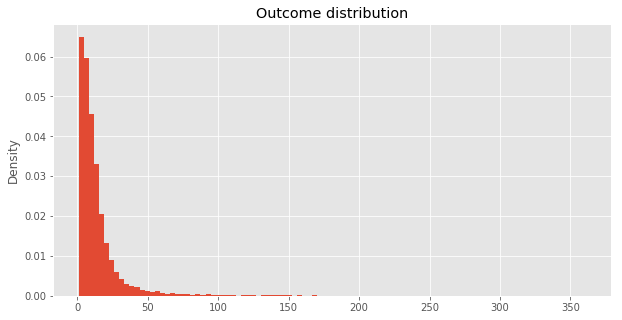

In [7]:
data.d360_dau_cum.hist(density=True, bins=100, figsize=(10, 5))
plt.ylabel("Density")
plt.title("Outcome distribution");

One interesting finding after applying logarithm is that we can see a lot of frequent vertical lines. Those generally come from small cohorts that either churn completely (hence the zero) or produce some other frequent discreet values like 1, 2 after normalization. 

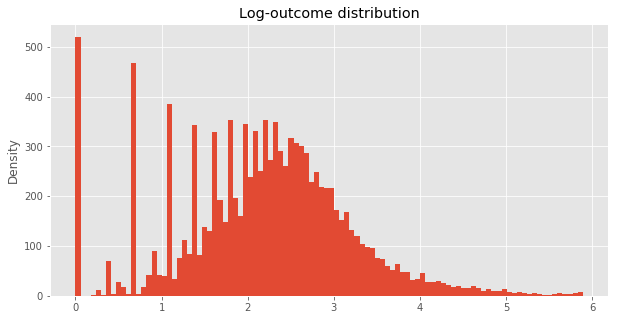

In [8]:
data.d360_dau_cum.apply(np.log).hist(bins=100, figsize=(10, 5))
plt.ylabel("Density")
plt.title("Log-outcome distribution");

If we now filter out small cohorts the log-distribution starts looking a lot better and resembles normal much more. 

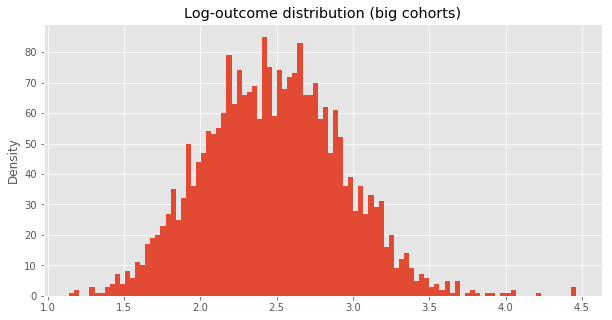

In [9]:
data.d360_dau_cum[data.cohort_size>50].apply(np.log).hist(bins=100, figsize=(10, 5))
plt.ylabel("Density")
plt.title("Log-outcome distribution (big cohorts)");

## Categorical variables

It might be interesting to find out how our target variable depends on the various categories that we have in the dataset.

As expected, the higher the country tier - the better engagement, retention and, consequently, LTV we have. 

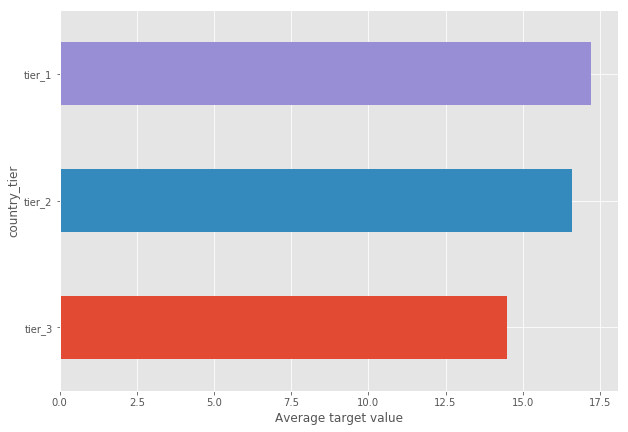

In [14]:
plt.figure(figsize=(10, 7))
data.groupby("country_tier").d360_dau_cum.mean().sort_values().plot.barh()
plt.xlabel("Average target value")
plt.show()

Interestingly enough, Board games seem to have the highest cumulative number of active players after one year. Seems like most loyal audience is there. 

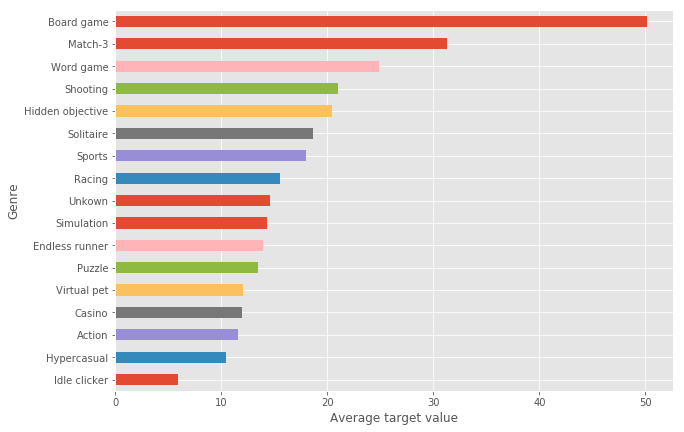

In [19]:
plt.figure(figsize=(10, 7))
data.groupby("Genre").d360_dau_cum.mean().sort_values().plot.barh()
plt.xlabel("Average target value")
plt.show()

However, Board games obviously have a limited audience, unlike Puzzle and Shooting games. 

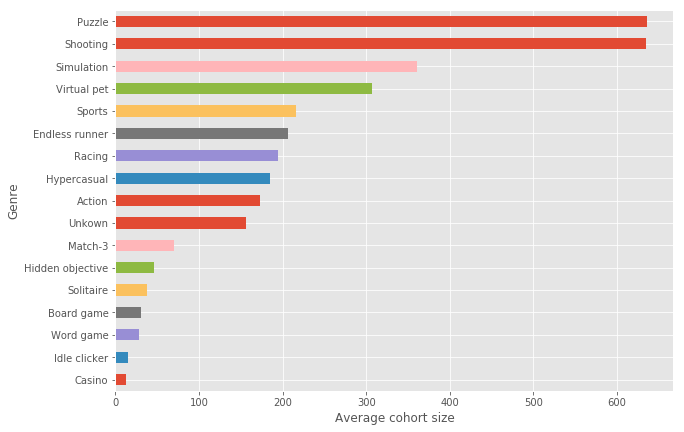

In [18]:
plt.figure(figsize=(10, 7))
data.groupby("Genre").cohort_size.mean().sort_values().plot.barh()
plt.xlabel("Average cohort size")
plt.show()

`country_isocode2` feature has quite a lot of unique values, most of which occur only once or twice in the dataset, so later in the preprocessing we will pay attention to encoding this feature carefully. 

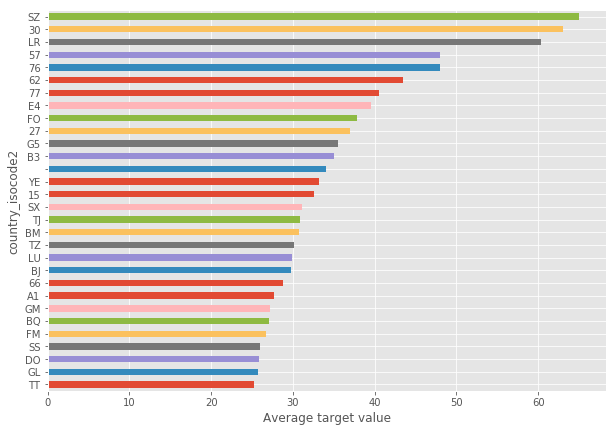

In [20]:
plt.figure(figsize=(10, 7))
data.groupby("country_isocode2").d360_dau_cum.mean().sort_values()[-30:].plot.barh()
plt.xlabel("Average target value")
plt.show()

Again as expected, most traffic comes from the United States and India, largest sources of the expensive top quality audience and cheap but mediocre traffic. 

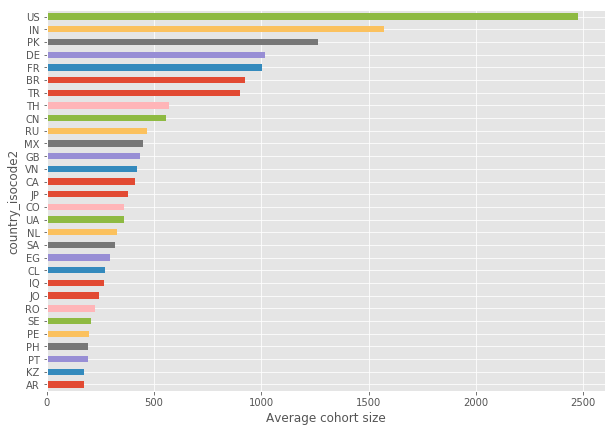

In [21]:
plt.figure(figsize=(10, 7))
data.groupby("country_isocode2").cohort_size.mean().sort_values()[-30:].plot.barh()
plt.xlabel("Average cohort size")
plt.show()

Another important thing is that we have quite a lot of observations where cohort size is extremely low, down to 1 or 2 installs. 

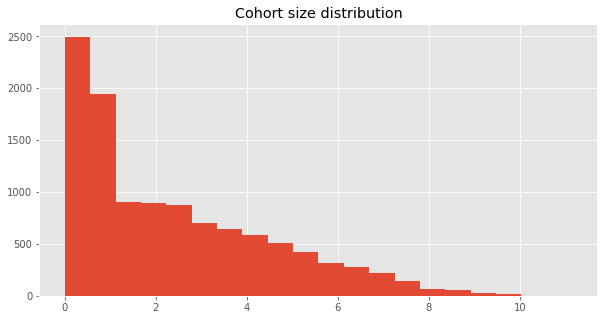

In [25]:
data.cohort_size.apply(np.log).hist(bins=20, figsize=(10, 5))
plt.title("Cohort size distribution")
plt.show()

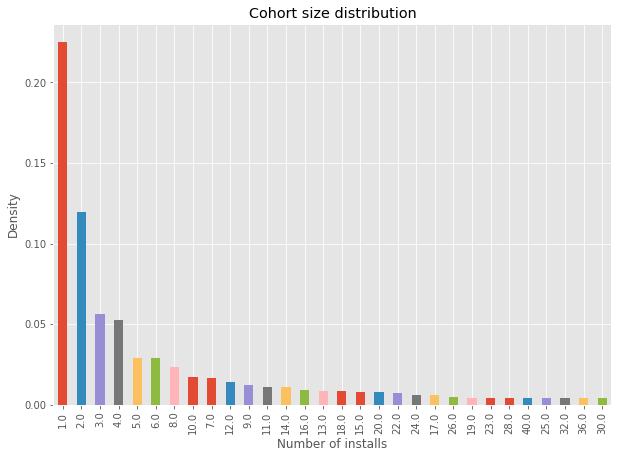

In [27]:
plt.figure(figsize=(10, 7))
data.cohort_size.value_counts(normalize=True)[:30].plot.bar()
plt.title("Cohort size distribution")
plt.ylabel("Density")
plt.xlabel("Number of installs")
plt.show()

## Scatters

Now let's have a look at how target variable depends on predictors. I will use only numeric features for now to plot scatters and measure linear correlation. 

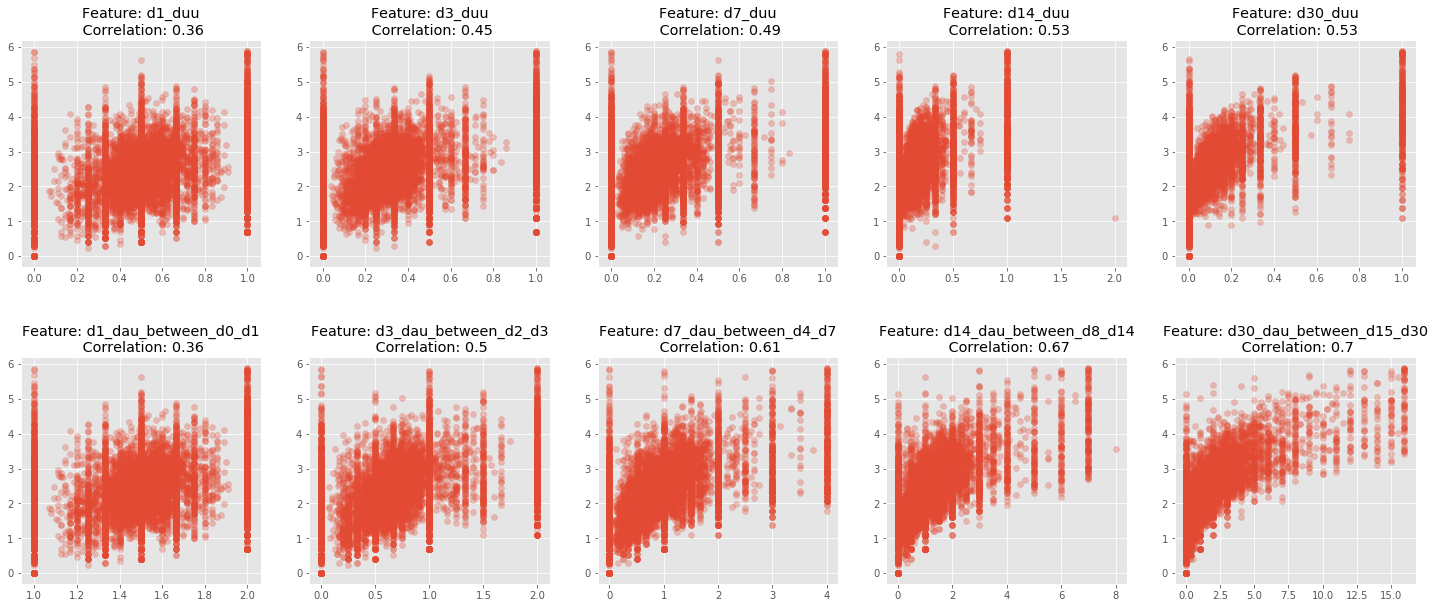

In [17]:
plot_scatters(data.iloc[:, 6:], data.d360_dau_cum)

So, judging from the plots above it's clear that we have a lot of repeating "discrete" values in all features (vertical lines). That happens due to small cohorts of size 1-2, that create discrete values after weighting by the cohort size. For example, a scatterplot of `d1_duu` predictor, which is the number of active players on day 1, has the biggest vertical lines on values 0 and 1 simply because small-sized cohorts with just 1 install can either return to the game or not. 

Generally, this is not a great pattern to have in data, since those vertical lines prevent us from calculating "true" correlations and later during modelling those observations will act as outliers that introduce a great deal of bias to the estimates. 

Let's see how the picture changes if we slightly increase the cohort size up to 10 installs per cohort. 

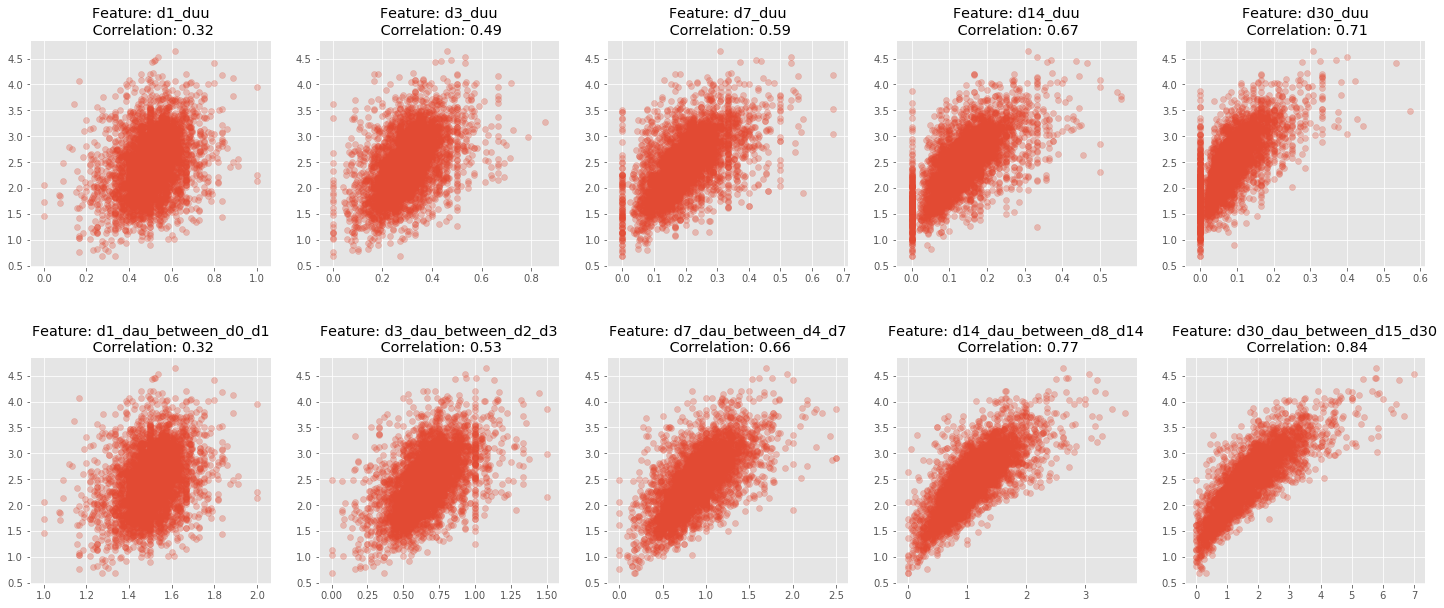

In [18]:
plot_scatters(data.iloc[:, 6:][data.cohort_size>10], data.d360_dau_cum[data.cohort_size>10])

Much better! Now almost all vertical lines are gone and correlations look much more convincing. However, due to low retention some lines near zero still remain, because not all cohorts survive up to **d3** let alone **d30**. 

Finally, it's time to see what happens when we move up to big cohorts (well, 50+ installs are not exactly big, but still):

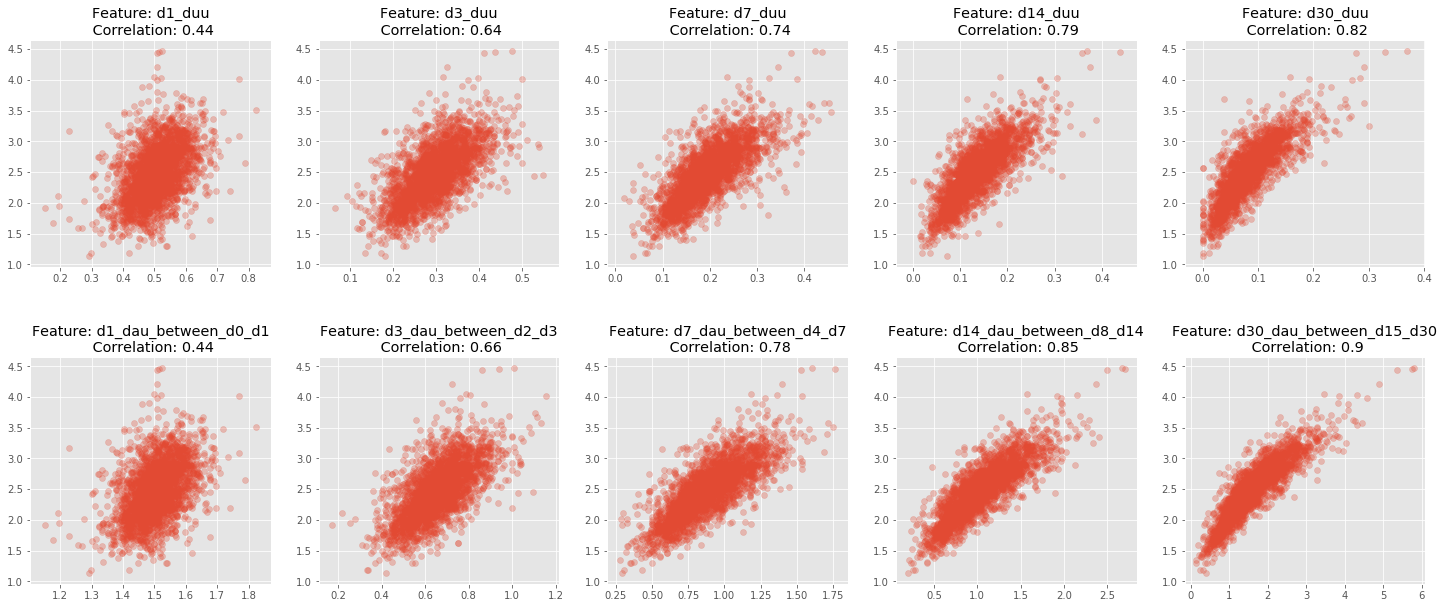

In [19]:
plot_scatters(data.iloc[:, 6:][data.cohort_size>50], data.d360_dau_cum[data.cohort_size>50])

Great! Almost "Boston price dataset" level of great. It's easy to see now that target variable is almost perfectly correlated with the last available day of cumulative number of active players, which is higly logical given the outcome also is a cumulative number of active players. Other features also exhibit high positive linear correlation, so it's good to check if our data actually has redundant features due to **multicollinearity**.

## Correlation heatmap

To answer the above question we can use a simple heatmap with pairwise correlations between all features:

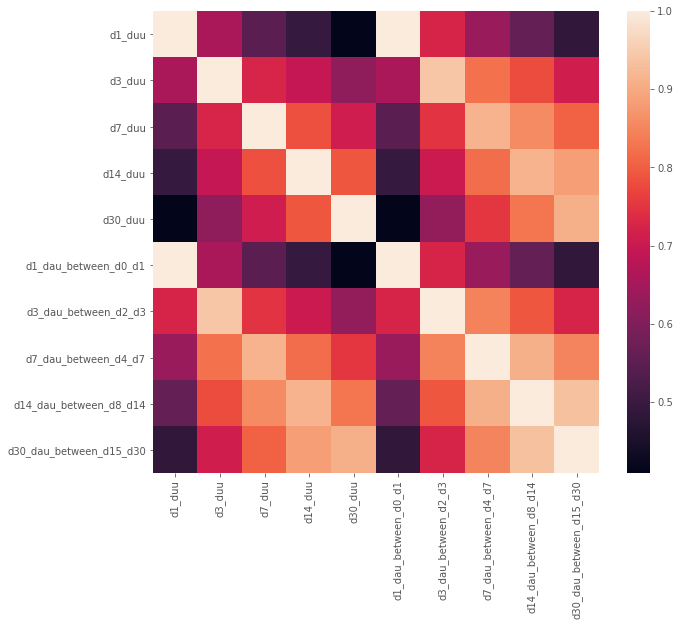

In [20]:
plt.figure(figsize=(10, 8.5))
sns.heatmap(data.iloc[:, 6:][data.cohort_size>50].corr());

It's clear from the plot above that there's a high level of multicollinearity in our data. Some features are even perfectly correlated and are plain duplicates, like `d1_duu` and `d1_dau_between_d0_d1` so we'll remove them later. 

This pattern is not great for linear models, especially for plain linear regression as higly correlated features can result in biased coefficients. To tackle with this problem we'll introduce regularization in the modelling section. 

# 2. Preprocessing

In this section, we will use DataPreprocessor module to clean up the data and transform categorical values unto numerical. 

For categorical features with a small number of unique values (`'operating_system', 'country_tier', 'Genre'`) it's best to apply simple one-hot encoding which will allow linear models to work with them easily. To avoid introducing additional multicollinearity during one-hot encoding first column from each encoding will be dropped from the resulting dataset. 

Since we have too many unique values for `country_isocode2` feature (323 to be precise), some of which are actually faulty, it's best not to over-expand our feature space with one-hot encoding, even though we will lose some interpretability for that particular feature, and choose one of the two appropriate approaches - target encoding or percentage encoding. 

The first approach calculates average target values across all unique categorical values and uses those values as encodings, the second one - calculates relative frequencies of each categorical value in the dataset and uses those percentages as encodings. 

Generally, the first approach is more informative for the models as it is directly connected to the outcome variable, so I will use it by default. Note, however, that in both cases one must calculate average target values or percentages **only** using the training part of the data to avoid information leak from unobserved data. 

Finally, since `cohort_size` was used as a weight and is not correlated with any other feature I will remove it from the dataset, but keep as a separate variable to use as a boolean mask for choosing various cohort sizes. 

In [5]:
cohort_size = data.cohort_size.copy()
X_train, X_holdout, y_train, y_holdout = train_test_split(
    data.drop(['d360_dau_cum', 'cohort_size'], axis=1), 
    data.d360_dau_cum,
    test_size=0.15, 
    random_state=7
)

In [6]:
data_preprocessor = DataPreprocessor()
data_preprocessor.fit(X_train, y_train)

X_train = data_preprocessor.transform(X_train, y_train)
X_holdout = data_preprocessor.transform(X_holdout, y_holdout)

While we are here, it's also worth checking the intrinsic dimentionality of our data, i.e. how far can we reduce the dimentionality of dataset while preserving most of its variance. Principal Component Analysis is exactly the tool we need as we are dealing with lineary correlated features, so using a linear dimentionality reduction technique is only logical:

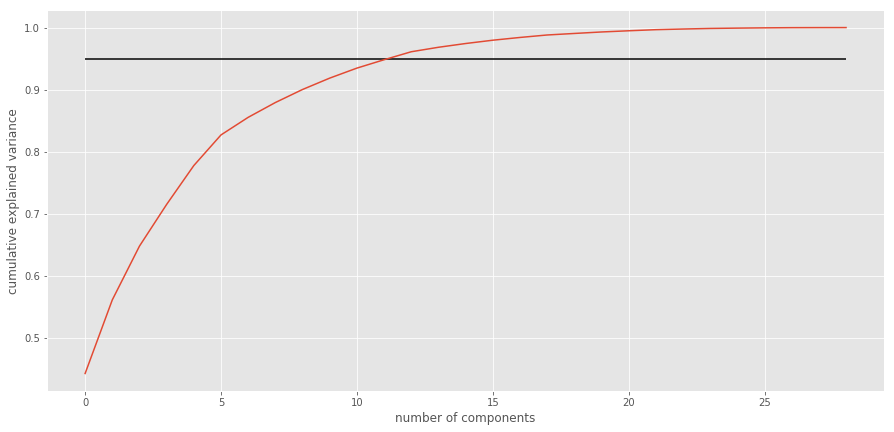

In [7]:
analyzePCA(X_train)

And it turns out that due to aforementioned multicollinearity, our 29 features can packed using a linear combination into just 11, while still preserving 95% of the initial variance. That again tells us we have quite a lot of useless predictors in data. 

# 3. Modelling

## Cohort size influence

In this section, I would like to elaborate more on how cohort size can influence the model performance. Naturally, we want to have forecasts for everything to make data-driven decisions. However, as we've seen in the exploratory analysis, small cohorts generally spoil the picture and can be considered outliers on most plots. What that means is that we can choose a threshold for the minimum number of installs per cohort that we actually can and want to have forecasts for. 

This is not only a data decision but also a business one, as having no forecasts for small cohorts means, that we are virtually blind and cannot optimize their acquisition campaigns. To make a decision let's have a look at how many installs we won't be able to optimize if we choose a certain minimal number of installs per cohort:

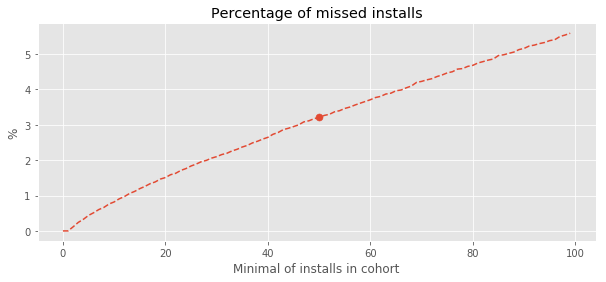

In [8]:
install_percentage_miss = []

for size in range(0, 100):
    small_cohort_installs = data[data.cohort_size<size].cohort_size.sum()
    big_cohort_installs = data[data.cohort_size>=size].cohort_size.sum()
    install_percentage_miss.append(100*small_cohort_installs/(small_cohort_installs+big_cohort_installs))
    
plt.figure(figsize=(10, 4))
plt.plot(install_percentage_miss, "--")
plt.scatter(50, install_percentage_miss[50], s=50)
plt.title("Percentage of missed installs")
plt.ylabel("%")
plt.xlabel("Minimal of installs in cohort")
plt.show()

Well, it turns out that small cohorts do not contribute much to the overall pull of installs and if we choose an optimal minimal number of installs from the modelling point of veiw - 50, we will **lose no more than 3.2%** of total installs. Naturally, this is still a huge number of installs, given the volumes of UA campaings, but as we will see further, it's best to make this sacrifice than to obtain nonrobust models. 

## Models and approach

Let's now create models that are capable of working with **cohorts of size 50+**. I will use two approaches - linear and non-linear and two models: **Lasso regression** and **XGB regressor** correspondingly. Additionally, **simple linear regression** is used as a reference point for Lasso regression and **random forest** - for XGBoost. 

As mentioned earlier, due to high multicollinearity in our data it is generally a good idea to use **regularization** for linear models to avoid overfitting and obtaining biased coefficient estimates, besides, as we suspect some features to be redundant it's possible to just drop them completely rather than having close to zero coefficients, hence, Lasso regression was chosen. 

As for the XGBoost, I decided to use it to understand to what extend **non-linear feature interactions** can produce better quality. Even though it's not exactly a "simple" model in theoretical sense. 

During training, we will monitor model quality by using a train-test split, where 15% of our data is reserved for testing purposes. I will also use cross-validation on training set for hyperparameter tuning. 

In terms of metrics, I will use **Mean Squared Error (MSE)**, **Mean Absolute Percentage Error (MAPE)** and **Coefficient of Determination (R2)**. The first metrics is selected as it is a most commonly used for regression tasks and allows for comparison of different models. However, it is not robust to outliers, so the second metrics which does not penalize for big mistakes as heavily is introduced. Besides, MAPE is an interpretable metrics and shows how, on average, our forecast is off. Finally, given almost linear nature of dependencies, R2 is used to show how well regression forecast aligns with the true outcome and what percentage of variance is successfully explained by the model. 

To visualize the results of training I will use **coefficient plots** for linear models and **feature importance** plots for non-linear models. That will allow us to interpret the models and understand what features are actually useful for prediction. 

Finally, to understand the quality of the forecasts and choose a better model I will use `plotPredictions` function which simultaneously analyses forecast results for several models, plots their distributions, actual values, calculates final metrics as well as correlations between forecasts (which is useful for understanding how coherent the models are). 

In [3]:
cohort_size = data.cohort_size.copy()
X_train, X_holdout, y_train, y_holdout = train_test_split(
    data.drop(['d360_dau_cum', 'cohort_size'], axis=1)[cohort_size>=50], 
    data.d360_dau_cum[cohort_size>=50],
    test_size=0.15, 
    random_state=7
)

print(X_train.shape, X_holdout.shape)

data_preprocessor = DataPreprocessor()
data_preprocessor.fit(X_train, y_train)

X_train = data_preprocessor.transform(X_train, y_train)
X_holdout = data_preprocessor.transform(X_holdout, y_holdout, train_set=False)

(2227, 14) (393, 14)


### Simple linear regression

Even such a simple model can already produce good results since our data has mostly linear dependencies. Although some weird coefficients are present (for example, **d14_duu** has a negative impact on our outcome which does not make any sence), the model still successfully explains almost 70% of variance and on average our forecasts are off by 17%. 

MSE constant:  49.73
MSE train:     9.50
MSE test:      11.02

MAPE constant: 37.86%
MAPE train:    18.57%
MAPE test:     16.89%

R2 train:      0.75
R2 test:       0.69


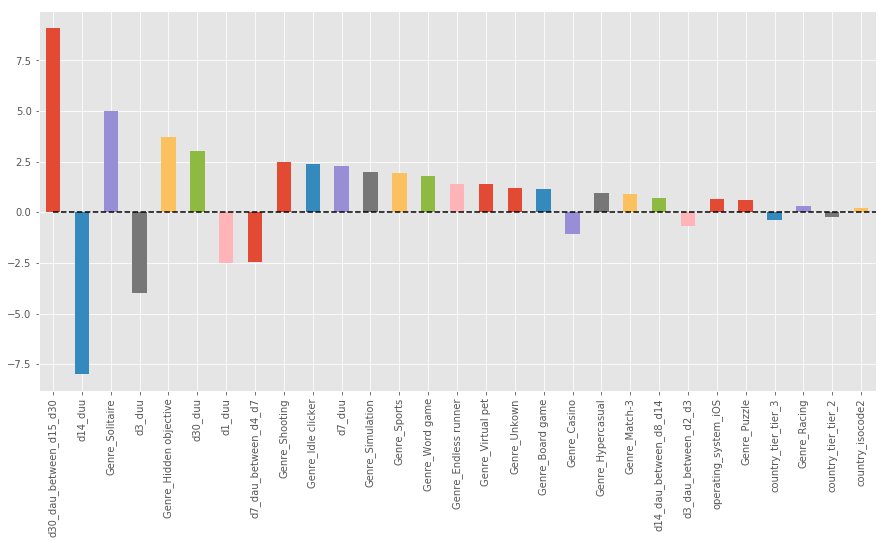

In [4]:
linreg = trainLinreg(X_train, X_holdout, y_train, y_holdout)

### Lasso regression

Now we add L1 regularization to our model and the results are much more adequate. The most "important" feature in terms of the absolute coefficient value is **d30_dau_between_d15_d30** which, as we discussed earlier, is higly logical. At the same time Lasso regression dropped some redundant features effectively reducing our feature space by half while still preserving same quality metrics. 

Best alpha: 0.01
MSE constant:  49.73
MSE train:     9.65
MSE test:      11.16

MAPE constant: 37.86%
MAPE train:    20.67%
MAPE test:     16.50%

R2 train:      0.74
R2 test:       0.68


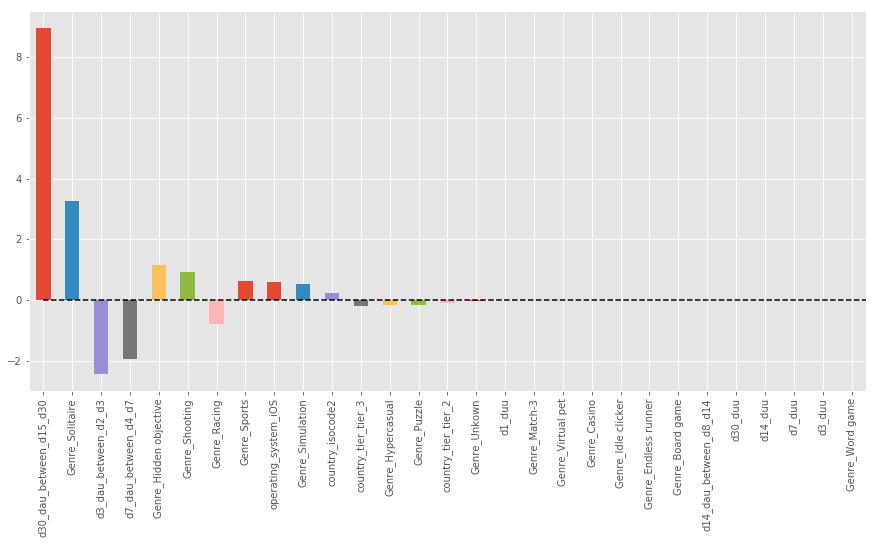

In [5]:
lasso_cv = trainLassoCV(X_train, X_holdout, y_train, y_holdout)

### Random forest

Judging by the metrics, it seems like non-linear interactions are actually useful for forecasts, since the model now is capable of explaining up to 77% of variance and on average is off by just 14%. Besides, on the feature importance plot we can see that there are just 3-4 variables that are actually useful for making predictions. 

{'n_estimators': 100, 'min_samples_split': 5, 'max_features': 21, 'max_depth': 6}
MSE constant:  49.73
MSE train:     5.76
MSE test:      8.42

MAPE constant: 37.86%
MAPE train:    12.05%
MAPE test:     14.25%

R2 train:      0.84
R2 test:       0.78


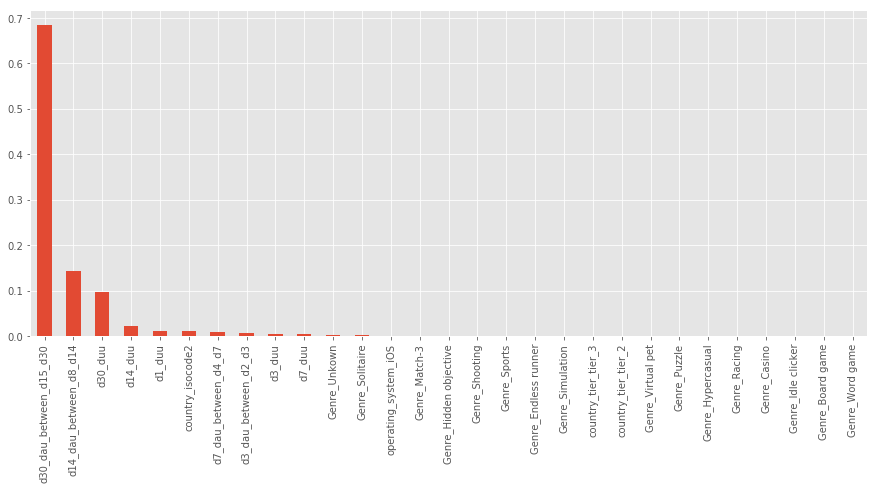

In [6]:
forest = trainForest(X_train, X_holdout, y_train, y_holdout, searchCV=True)

### XGBoost regressor

Our final model shows the best results and tries to use as much information from the features as possible. It is also the only model that managed to get some use from our target-encoded `country_isocode2` feature. As a result, we are up to 83% of explained variance. However, on average, the forecasts are still off by 14%.

{'subsample': 0.75, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 1.0}
MSE constant:  49.73
MSE train:     3.39
MSE test:      6.64

MAPE constant: 37.86%
MAPE train:    10.70%
MAPE test:     14.12%

R2 train:      0.92
R2 test:       0.83


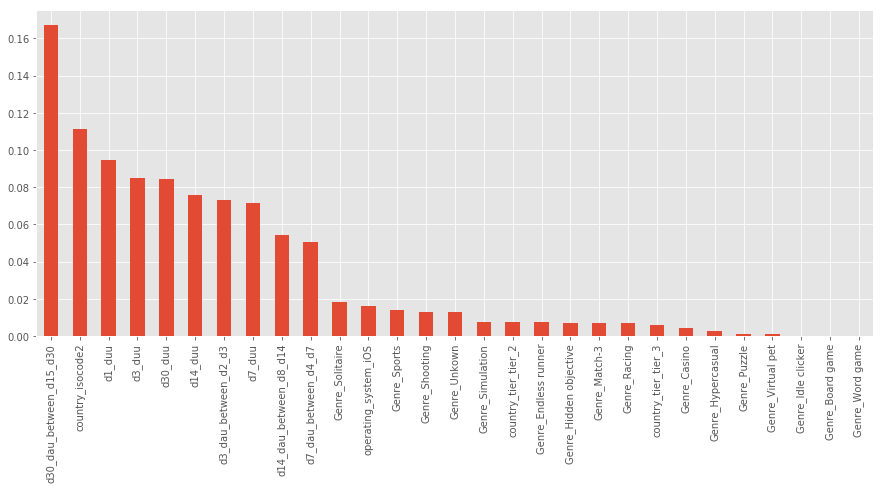

In [10]:
xgb = trainXGB(X_train, X_holdout, y_train, y_holdout, searchCV=True)

# 4. Performance analysis

Now let's see the final prediction plot, where all 4 models (2 reference-models and 2 main) are analysed. 

As can be seen from the Kernel density estimation plot, where all forecast distributions are plotted, as well as the target variable, all 4 models are generally **very close** and follow the same patterns. 

Now from the Predictions and Predictions (sorted) plots, it's clear that on average the models are making **correct forecasts** and even some extremely high values of the target variable are forecasted properly. 

It also seems like Linear regression and Lasso regression models are perfectly aligned as the correlation between them is exactly 1. That once again proves that adding regularization was a good step as reducing feature space yielded the same quality results. 

Finally, judging by the quality metrics, **XGBoost regressor model should be selected** as it gives us the lowest errors and the highest percentage of explained variance. 

However, this is only true for the case when our future data will not have significant scale shifts. As XGBoost is a tree-based model, it can have **a hard time extrapolating** from the unseen before extreme values. E.g., if we have a cohort with extremely large `d30_dau_between_d15_d30` value which has never appeared in the training set, XGB will fail to return a correspondingly large forecast as it will be limited by the maximum target value it has observed before. At the same time, **simple linear model** will be able to extrapolate and the forecast will not be unreasonably low. 

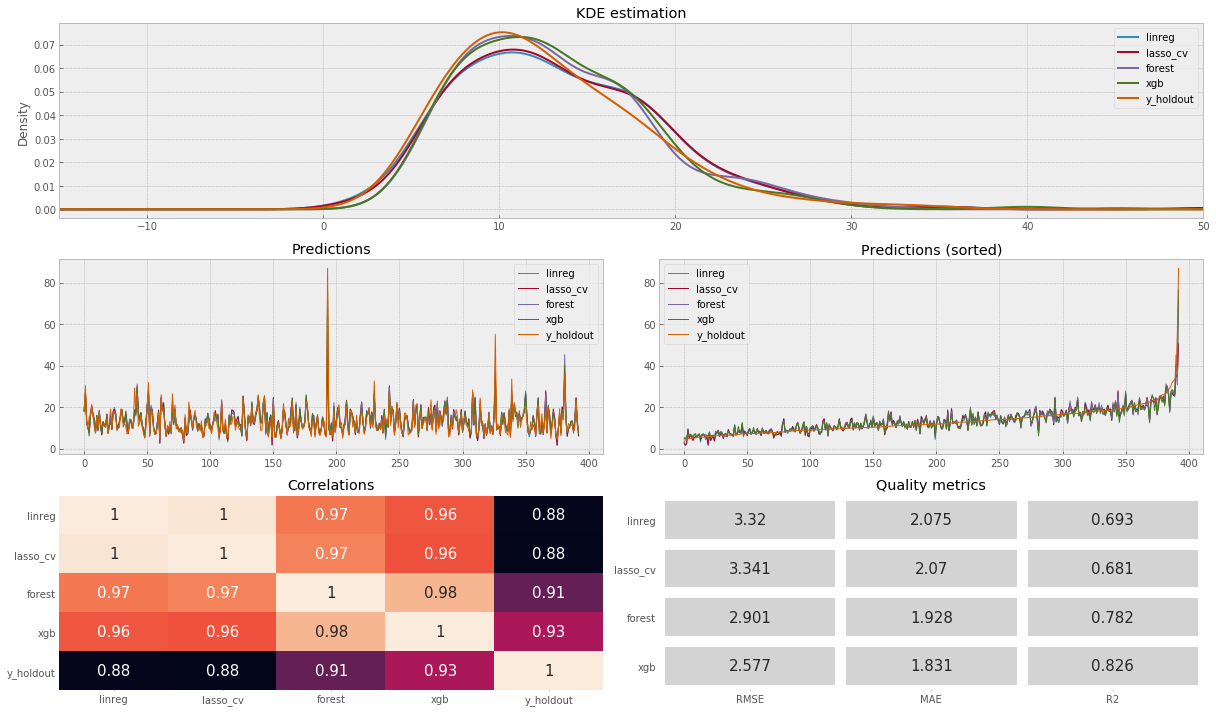

In [11]:
predictions = getPredictions(linreg, lasso_cv, forest, xgb, X_holdout, y_holdout)
plotPredictions(predictions)

Finally, just to show what could happen if we did not sacrifice a certain amount of installs and tried to create forecasts even for small-sized cohorts. Naturally, having that amount of outliers in data prevents us from building adequate models and most of them are unable to predict anything with a resonable quality. 

(9420, 29) (1663, 29)


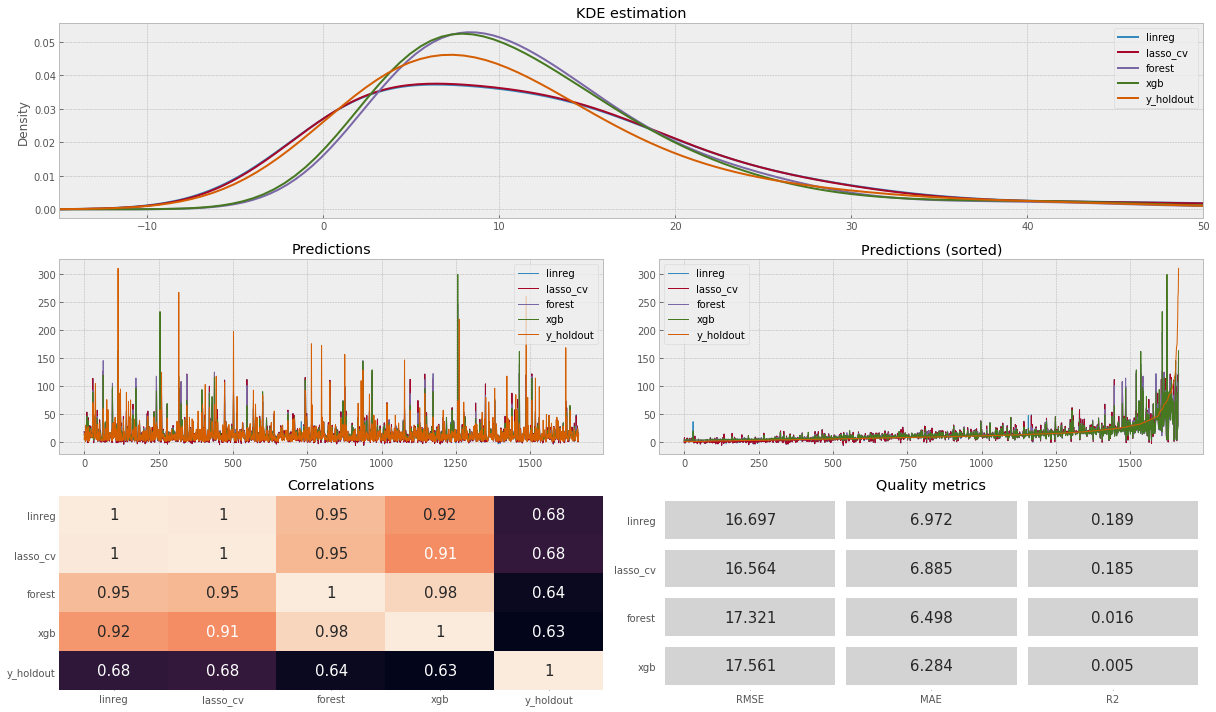

In [37]:
run_training(data, size=0)

The reason behind my choice is that it directly influences UA team and affects their targets. As I've described above, this plot can be used to discuss the threshold of the cohort size which is suitable for modelling purposes and does not eliminate too many installs from the UA optimization process. 

Using this plot we can estimate potential financial risks form overlooking a certain percentage of installs and find a compromise solution. Basically, this is one of the first things I would discuss with UA team before doing any modelling whatsoever :) 

Regarding conclusions and recommendations - we need to find a good tradeoff between the minimal cohort size that we actually can give forecast for and the percentage of uncovered installs. My recommendation would be to sacrifice a portion of our traffic to make sure that we really can trust model predictions and optimize campaings based on those forecasts. It is also possible to extrapolate forecasts of big cohorts onto the small ones using simple averages by sources, countries, etc. I.e. if we have a forecast for several big cohorts coming from US Puzzle, we can use average as a forecast for all small cohorts from the same group and this way approximate even the remaining 3% of traffic. 